<a href="https://colab.research.google.com/github/mdmarghe/DeepLearning/blob/main/HousePrices_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DATI

Boston House prices analisi
Regressione lineare continua (da non confondere con algoritmo di regressione logistica che risolve un problema di classificazione)


In [ ]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Le varie caratteristiche dei dati di input hanno scale diverse--> Vogliamo normalizzare i dati affinchè ogni caratteristica sia su una stessa scala di valori

In [ ]:
train_data.shape

(404, 13)

In [ ]:
test_data.shape

(102, 13)

Abbiamo veramente pochi dati!

In [ ]:
train_targets[0] #la prima casa del dataframe costa 15,2k dollari

np.float64(15.2)

##Preparazione Dati
###Normalizzazione delle caratteristiche dei dati: ogni colonna verrà sottratta del vettore media e divisa per il valore deviazione standard. Con questo metodo avremo una distribuzione centrata in 0 e con deviazione standard unitaria.

In [ ]:
mean=train_data.mean(axis=0)
train_data-=mean
std=train_data.std(axis=0)
train_data/=std
test_data-=mean
test_data/=std


In [ ]:
train_data[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

#Creazione della rete
Siccome la rete ha a disposizione pochissimi dati sarà sottoposta maggiormente all'overfitting.
Utilizzeremo dunque il metodo delle K-fold per convalidare la nostra rete: Suddividiamo il campione di addestramento in k gruppi e iteriamo l'addestramento della rete k volte, ogni volta con k-1 gruppi di addestramento e uno di convalida. Questo ci permette di capire di quante epoche potremmo avere bisogno in maniera omogenea.


In [ ]:
from keras import layers, models

##Funzione di attivazione, funzione obiettivo e metrica
L'ultimo layer della rete non deve avere attivazione perchè deve essere un layer lineare e una attivazione (es una sigmoide) ci limiterebbe l'intervallo di predizione.
La funzione obiettivo mse, mean squared error utilizzata per regressioni.
La metrica Mae, mean absolute error, ci dice di quanto si scosta il prezzo dalla media.

In [ ]:
def build_model():
  model=models.Sequential()
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

##Convalida approccio
The best practice in such situations is to use K-fold cross-validation. It consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating K identical models, and training each one on K – 1 partitions while evaluating on the remaining partition. The validation score for the model used is then the average of the K validation scores obtained.

In [ ]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]    #1
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(                                     #2
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()                                                    #3
    model.fit(partial_train_data, partial_train_targets,                     #4
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)      #5
    all_scores.append(val_mae)

#1 - Prepares the validation data: data from partition #k
#2 - Prepares the training data: data from all other partitions
#3 - Builds the Keras model (already compiled)
#4 - Trains the model (in silent mode, verbose = 0)
#5 - Evaluates the model on the validation data


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [ ]:
all_scores

[2.372671365737915, 2.5038106441497803, 3.1102418899536133, 2.413869619369507]

In [ ]:
np.mean(all_scores)

np.float64(2.600148379802704)

##Retrain a 500 epoche

In [ ]:
num_epochs = 200
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]    #1
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(                                     #2
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()                                                    #3
    history = model.fit(partial_train_data, partial_train_targets,           #4
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

#1 - Prepares the validation data: data from partition #k
#2 - Prepares the training data: data from all other partitions
#3 - Builds the Keras model (already compiled)
#4 - Trains the model (in silent mode, verbose=0)



processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [ ]:
for key in history.history.keys():
  print(key)

loss
mae
val_loss
val_mae


In [ ]:
average_mae_history=[np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

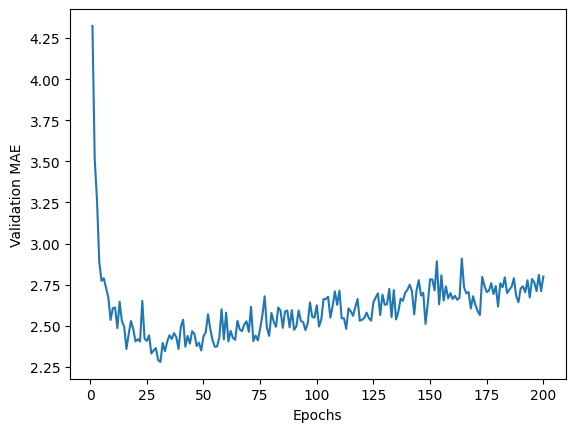

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Siccome i primi 10 punti sono in una scala differente rispetto ahli altri, li eliminiamo per vedere meglio l'errore medio assoluto. Inoltre potremo sostituire ogni punto con una media mobile esponenziale dei punti precedenti (assi che la curva sia più uniforme)

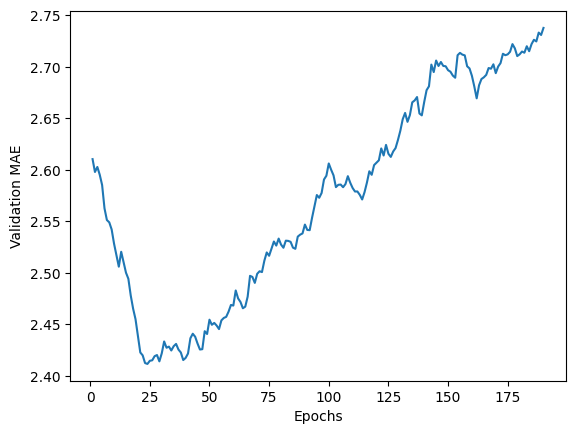

In [19]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Possiamo dire che dopo 37 epoche più o meno l'errore smette di diminuire e si inizia a manifestare overfitting.

##Modello finale

In [26]:
model = build_model()                                                     #1
model.fit(train_data, train_targets,                                      #2
          epochs=37, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

#1 - Gets a fresh, compiled model
#2 - Trains it on the entirety of the data


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.3160 - mae: 2.8032 


In [28]:
test_mae_score  #il prezzo previsto +- questa variabile. ci dice di quanto stiamo sbagliando il calcolo in media

3.034682273864746